# Defs and loads

In [19]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import partridge as ptg
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

from src.utils.time import name_to_day
from src.data_filter import load_train_test_split

data_path = Path('..','shared','data')

In [32]:
records = load_train_test_split(data_path)

days = {i: [] for i in range(7)}
for scope in records:
    for record in records[scope]:
        day = name_to_day(record)[0]
        days[day].append(record)

for day in days:
    days[day] = {
        'train': days[day][0],
        'test': days[day][1],
    }

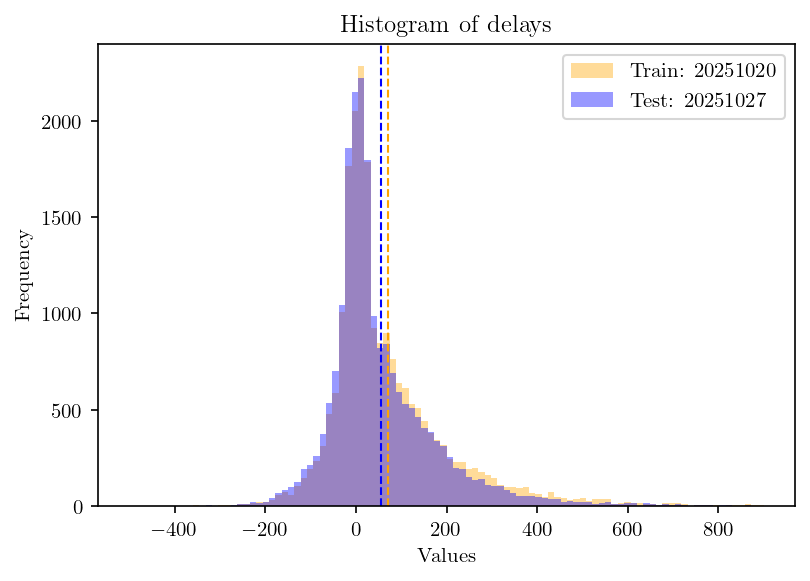

In [34]:
day = 0  # 0: Monday, 1: Tuesday, ..., 6: Sunday

plt.figure(figsize=(6,4),dpi=150)

train_day = days[day]['train']
test_day = days[day]['test']
df_train = pd.read_csv(data_path / 'delays' / f'{train_day}.csv', sep=',', low_memory=False)
df_test = pd.read_csv(data_path / 'delays' / f'{test_day}.csv', sep=',', low_memory=False)

plt.hist(df_train["delay"], bins=100, range=(-500, 900), color="orange", alpha=0.4, label=f'Train: {train_day}')
plt.hist(df_test["delay"], bins=100, range=(-500, 900), color="blue",alpha=0.4, label=f'Test: {test_day}')

plt.axvline(df_train["delay"].mean(), color="orange", linestyle="--", linewidth=1)
plt.axvline(df_test["delay"].mean(), color="blue", linestyle="--", linewidth=1)

plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title(f"Histogram of delays")
plt.legend()
plt.show()

In [35]:
# MODELS
class PeriodRouteModel:

    """
    A napszak és a route figyelembevételével becsül átlag késést
    """
    
    def __init__(self, bins):
        self.labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
        self.bins = [b*60*60 for b in bins]

    def fit(self,record):

        df = pd.read_csv(data_path / 'delays' / f'{record}.csv', sep=',', low_memory=False)
        df["period"] = pd.cut(df['trip_start'],bins=self.bins,labels=self.labels)

        self.model = (
            df.groupby(["period", "route_id"], observed=False)["delay"]
            .mean()
            .dropna()
            .to_dict()
        )
    
    def evaluate(self,record):
        df = pd.read_csv(data_path / 'delays' / f'{record}.csv', sep=',', low_memory=False)
        df["period"] = pd.cut(df['trip_start'],bins=self.bins,labels=self.labels)

        df["pred_delay"] = df.apply(
            lambda r: self.model.get((r["period"], r["route_id"])),
            axis=1
        ).fillna(0)

        rmse = np.sqrt(mean_squared_error(df["delay"], df["pred_delay"]))
        mae = mean_absolute_error(df["delay"], df["pred_delay"])

        return rmse, mae


class RouteModel:
    
    """
    A route figyelembevételével becsül átlag késést
    """

    def __init__(self):
        pass

    def fit(self,record):
        df = pd.read_csv(data_path / 'delays' / f'{record}.csv', sep=',', low_memory=False)
        self.model = (
            df.groupby(["route_id"], observed=False)["delay"]
            .mean()
            .dropna()
            .to_dict()
        )
    
    def evaluate(self,record):
        df = pd.read_csv(data_path / 'delays' / f'{record}.csv', sep=',', low_memory=False)
        df["pred_delay"] = df.apply(
            lambda r: self.model.get(r["route_id"]),
            axis=1
        ).fillna(0)

        rmse = np.sqrt(mean_squared_error(df["delay"], df["pred_delay"]))
        mae = mean_absolute_error(df["delay"], df["pred_delay"])

        return rmse, mae

In [ ]:
for day in days:
    rec_train = days[day]['train']
    rec_test = days[day]['test']
    days[day]['eval'] = {}

    model = PeriodRouteModel(bins=[0,6,9,15,18,24])
    model.fit(rec_train)
    rmse, mae = model.evaluate(rec_test)

    days[day]['eval']['PeriodRouteModel'] = {
        'rmse': rmse, 'mae': mae
    }
    model = RouteModel()
    model.fit(rec_train)
    rmse, mae = model.evaluate(rec_test)

    days[day]['eval']['RouteModel'] = {
        'rmse': rmse, 'mae': mae
    }

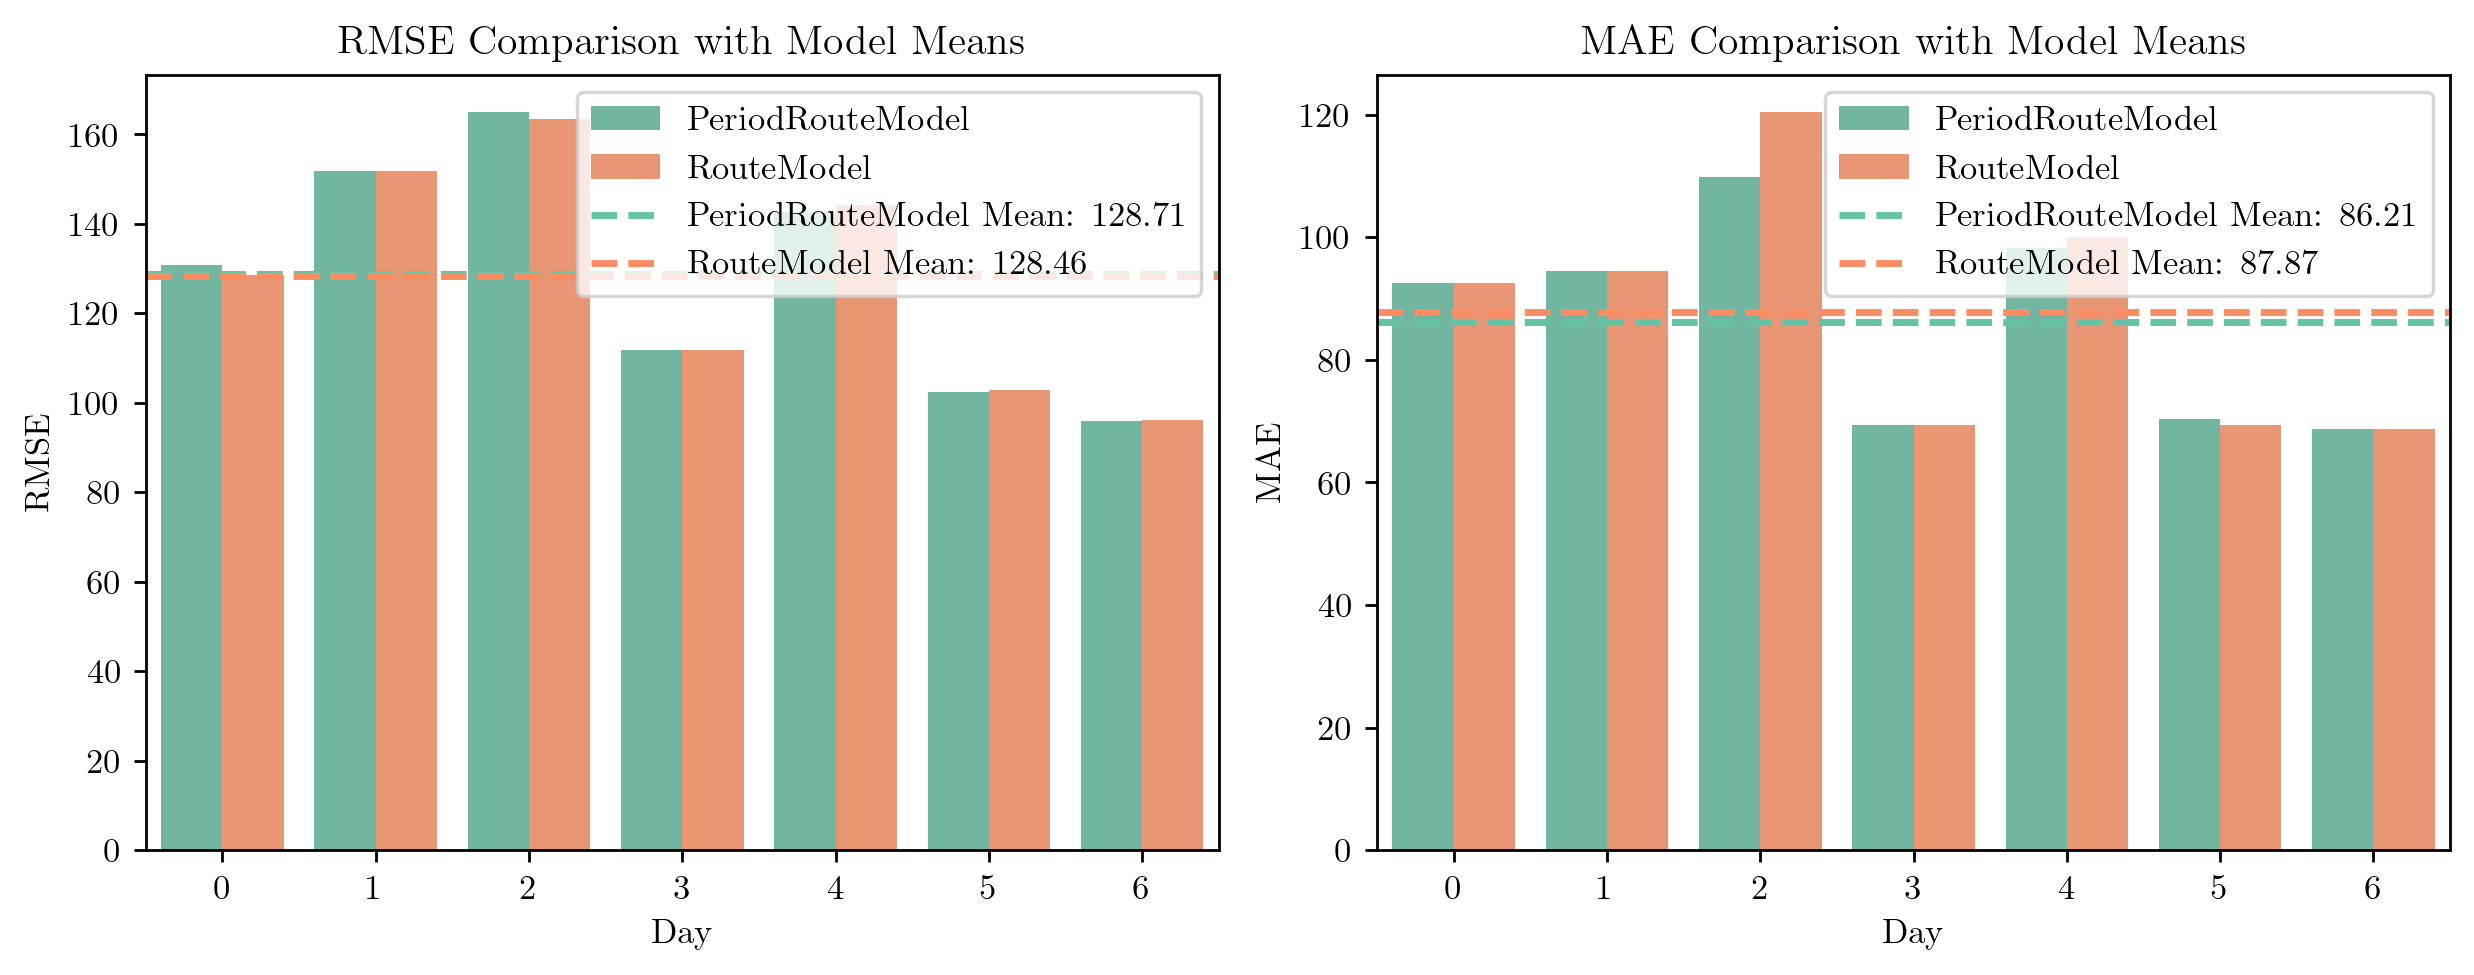

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Flatten the dictionary into a list of records for plotting
plot_data = []
for day_idx, content in days.items():
    if 'eval' in content:
        for model_name, metrics in content['eval'].items():
            plot_data.append({
                'Day': day_idx,
                'Model': model_name,
                'RMSE': metrics['rmse'],
                'MAE': metrics['mae']
            })

# 2. Create DataFrame
df_results = pd.DataFrame(plot_data)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate means for each model across all days
# Assuming df_results is the DataFrame created previously
means = df_results.groupby('Model')[['RMSE', 'MAE']].mean()

# 2. Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=250)
palette = sns.color_palette("Set2")

# RMSE Subplot
sns.barplot(data=df_results, x='Day', y='RMSE', hue='Model', ax=ax1, palette='Set2')
ax1.set_title('RMSE Comparison with Model Means')

# Add mean lines for RMSE
for i, model in enumerate(df_results['Model'].unique()):
    m_val = means.loc[model, 'RMSE']
    ax1.axhline(m_val, color=palette[i], linestyle='--', 
                linewidth=2, label=f'{model} Mean: {m_val:.2f}')

# MAE Subplot
sns.barplot(data=df_results, x='Day', y='MAE', hue='Model', ax=ax2, palette='Set2')
ax2.set_title('MAE Comparison with Model Means')

# Add mean lines for MAE
for i, model in enumerate(df_results['Model'].unique()):
    m_val = means.loc[model, 'MAE']
    ax2.axhline(m_val, color=palette[i], linestyle='--', 
                linewidth=2, label=f'{model} Mean: {m_val:.2f}')

# Refresh legends to include the mean line labels
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()